# Example of Kalman Filter decoders

This example is similar to those shown in "Examples_all_decoders."
However, there is some preprocessing is different for the Kalman, so we have made a separate notebook.

In this example notebook, we:
1. Import the necessary packages
2. Load a data file (spike trains and outputs we are predicting)
3. Preprocess the data
4. Run the decoders and print the goodness of fit
5. Plot example decoded outputs

## 1. Import Packages

Below, we import both standard packages, and functions from the accompanying .py files

Note that you may need to specify the path below

In [1]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
import sys

#Add the main folder to the path, so we have access to the files there.
#Note that if your working directory is not the Examples_hippocampus folder, you may need to manually specify the path to the main folder. For example: sys.path.append('/home/jglaser/GitProj/Neural_Decoding')
sys.path.append('..') 

#Import metrics
from metrics import get_R2
from metrics import get_rho

#Import decoder functions
from decoders import KalmanFilterDecoder

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 40.0% of memory, cuDNN 5103)


## 2. Load Data
The data for this example can be downloaded at this [link](https://www.dropbox.com/s/e9mul73ur9omu5f/example_data_hc.pickle?dl=0).

It is the hc-2 dataset from [crcns](https://crcns.org/data-sets/hc/hc-2). Specifically, we use the dataset "ec014.333" 


The data that we load is in the format described below. We have another example notebook, "Example_format_data_hc", that may be helpful towards putting the data in this format.

Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

In [2]:
folder='' #ENTER THE FOLDER THAT YOUR DATA IS IN
# folder='/home/jglaser/Data/DecData/' 
# folder='/Users/jig289/Dropbox/Public/Decoding_Data/'

with open(folder+'example_data_hc.pickle','rb') as f:
#     neural_data,pos_binned=pickle.load(f,encoding='latin1') #If using python 3
    neural_data,pos_binned=pickle.load(f) #If using python 2

## 3. Preprocess Data

### 3A. User Inputs
The user can define what time period to use spikes from (with respect to the output).

In [3]:
lag=0 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)

### 3B. Format Covariates

#### Format Input

In [4]:
#Remove neurons with too few spikes in HC dataset
nd_sum=np.nansum(neural_data,axis=0) #Total number of spikes of each neuron
rmv_nrn=np.where(nd_sum<100) #Find neurons who have less than 100 spikes total
neural_data=np.delete(neural_data,rmv_nrn,1) #Remove those neurons

In [5]:
#The covariate is simply the matrix of firing rates for all neurons over time
X_kf=neural_data

#### Format Output

In [6]:
#For the Kalman filter, we use the position, velocity, and acceleration as outputs
#Ultimately, we are only concerned with the goodness of fit of position (for this dataset)
#But using them all as covariates helps performance

#We now determine velocity
temp=np.diff(pos_binned,axis=0)
vels_binned=np.concatenate((temp,temp[-1:,:]),axis=0)

#We now determine acceleration
temp2=np.diff(vels_binned,axis=0)
acc_binned=np.concatenate((temp2,temp2[-1:,:]),axis=0)

y_kf=np.concatenate((pos_binned,vels_binned,acc_binned),axis=1)

In [7]:
#Remove time bins with no output (y value)
rmv_time=np.where(np.isnan(y_kf[:,0]) | np.isnan(y_kf[:,1]))
X_kf=np.delete(X_kf,rmv_time,0)
y_kf=np.delete(y_kf,rmv_time,0)

### 3C. Take lag into account

In [8]:
num_examples=X_kf.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]

### 3D. Split into training/testing/validation sets
Note that parameters should be setting using a separate validation set. 
Then, the goodness of fit should be be tested on a testing set (separate from the training and validation sets).

### User Options

In [9]:
#Set what part of data should be part of the training/testing/validation sets
#Note that there was a long period of no movement after about 80% of recording, so I did not use this data.
training_range=[0, 0.5]
valid_range=[0.5,0.65]
testing_range=[0.65, 0.8]

### Split Data: For KF

In [10]:
#Number of examples after taking into account bins removed for lag alignment
num_examples_kf=X_kf.shape[0]
        
#Note that each range has a buffer of 1 bin at the beginning and end
#This makes it so that the different sets don't include overlapping data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples_kf))+1,np.int(np.round(training_range[1]*num_examples_kf))-1)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples_kf))+1,np.int(np.round(testing_range[1]*num_examples_kf))-1)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples_kf))+1,np.int(np.round(valid_range[1]*num_examples_kf))-1)

#Get training data
X_kf_train=X_kf[training_set,:]
y_kf_train=y_kf[training_set,:]

#Get testing data
X_kf_test=X_kf[testing_set,:]
y_kf_test=y_kf[testing_set,:]

#Get validation data
X_kf_valid=X_kf[valid_set,:]
y_kf_valid=y_kf[valid_set,:]

### 3E. Preprocessing: Normalization and zero-centering
We normalize (z_score) the inputs and zero-center the outputs.
Parameters for z-scoring (mean/std.) should be determined on the training set only, and then these z-scoring parameters are also used on the testing and validation sets.

In [11]:
#Z-score inputs 
X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
X_kf_train_std=np.nanstd(X_kf_train,axis=0)
X_kf_train=(X_kf_train-X_kf_train_mean)/X_kf_train_std
X_kf_test=(X_kf_test-X_kf_train_mean)/X_kf_train_std
X_kf_valid=(X_kf_valid-X_kf_train_mean)/X_kf_train_std

#Zero-center outputs
y_kf_train_mean=np.mean(y_kf_train,axis=0)
y_kf_train=y_kf_train-y_kf_train_mean
y_kf_test=y_kf_test-y_kf_train_mean
y_kf_valid=y_kf_valid-y_kf_train_mean

## 4. Run Decoder
Note that in this example, we are evaluating the model fit on the validation set

### Kalman Filter

In [12]:
#Declare model
model_kf=KalmanFilterDecoder(C=5) #There is one optional parameter (see ReadMe)

#Fit model
model_kf.fit(X_kf_train,y_kf_train)

#Get predictions
y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)

#Get metrics of fit (see read me for more details on the differences between metrics)
#First I'll get the R^2
R2_kf=get_R2(y_kf_valid,y_valid_predicted_kf)
print('R2:',R2_kf[0:2]) #I'm just printing the R^2's of the 1st and 2nd entries that correspond to the positions
#Next I'll get the rho^2 (the pearson correlation squared)
rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)
print('rho2:',rho_kf[0:2]**2) #I'm just printing the rho^2's of the 1st and 2nd entries that correspond to the positions

('R2:', array([ 0.27339992,  0.43781966]))
('rho2:', array([ 0.31972619,  0.45937202]))


## 5. Make Plots

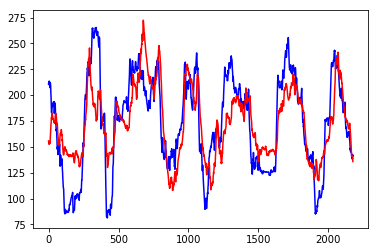

In [13]:
#As an example, I plot an example 3000 values of the x position (column index 0), both true and predicted with the Kalman filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_kf=plt.figure()
plt.plot(y_kf_valid[2000:5000,0]+y_kf_train_mean[0],'b')
plt.plot(y_valid_predicted_kf[2000:5000,0]+y_kf_train_mean[0],'r')
#Save figure
# fig_x_kf.savefig('x_position_decoding.eps')